<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter06/ch6_nb6_build_and_train_a_unet_for_urban_object_and_instance_segmentation.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 6: Enhancing and Segmenting Images </strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 6:</small><br/>Building and Training a U-Net Model <br/>for Object and Instance Segmentation</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In the previous <a href="./ch6_nb5_semantic_segmentation_for_smart_cars.ipynb" title="Notebook 6-5">notebook</a>, we presented how to build and train a <em>FCN-8s</em> model for semantic segmentation, applied to the Cityscapes dataset for self-driving applications.
<br/><br/>
This time, we will tackle the same task but from a different angle. We will reuse the <em><strong>U-Net</em></strong> architecture we implemented in <a href="./ch6_nb3_improve_image_quality_with_dae.ipynb" title="Notebook 6-3">Notebook 6-3</a>, demonstrate how the <em><strong>Dice</em></strong> loss can be applied to our use-case, and use a pre-trained <em><strong>Conditional Random Fields (CRFs)</em></strong> method to post-process our predictions. Finally, we will apply another pre-trained solution to our label maps, to achieve <em><strong>instance segmentation</em></strong>. 
<br/><br/>
<em><strong>Note:</em></strong> Sections of this notebook are copied previous notebooks, and several methods are directly imported without further explanations. Please refer to the aforementioned notebooks for details.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

random_seed = 42 # Fixing the seed for PRNGs, to help reproducibility
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

***Note:*** The following experiments are compute-heavy (large model and dataset). Make sure the procedures are performed on GPU(s) -- refer to Chapter 2 for alternatives. You can also opt for a shallower network or smaller input images.

## Preparing the Dataset

We dedicated a previous [notebook](./ch6_nb4_data_preparation_for_smart_car_apps.ipynb) to setting up the input pipeline for the Cityscapes data[$^1$](#ref). It is now just a matter of importing our helper functions and instantiate our `tf.data.Dataset` accordingly: 

In [2]:
from cityscapes_utils import (
    CITYSCAPES_FOLDER, # change this variable to Cityscapes root folder
    CITYSCAPES_LABELS, CITYSCAPES_IGNORE_VALUE, 
    cityscapes_input_fn, get_cityscapes_file_pairs,
    postprocess_to_show, change_ratio)

from plot_utils import plot_image_grid

In [3]:
batch_size     = 8
num_epochs     = 90
image_size     = [512, 512]
num_channels   = 3
num_classes    = len(CITYSCAPES_LABELS)
random_seed    = 1
num_show       = 3

In [4]:
num_train_imgs = len(get_cityscapes_file_pairs(split='train', 
                                               root_folder=CITYSCAPES_FOLDER)[0])
num_val_imgs   = len(get_cityscapes_file_pairs(split='val', 
                                               root_folder=CITYSCAPES_FOLDER)[0])

train_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=random_seed)
val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=False, num_epochs=1, augment=False, seed=random_seed)

# For visualization purpose, we also create a validation dataset using the images 
# with blurred faces/immatriculation plates (for privacy). As we will just use 
# 2-3 images, we only create the `tf.data.Dataset` to grab one batch:
visual_val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=num_show,
    shuffle=True, num_epochs=1, augment=False, seed=random_seed, blurred=True)

val_image_samples, val_gt_samples = next(visual_val_dataset.__iter__())
del visual_val_dataset

In [5]:
import math

# Number of batches per train/val epoch, to guide the Keras `fit` method:
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

## Building a U-Net Model for Semantic Segmentation

In Chapter 6, we presented the **_U-Net_ architectures**[$^2$](#ref), which we already re-implemented and used for super-resolution in a Notebook [6-3](./ch6_nb3_super_resolution_with_dae.ipynb). We will now train and apply it to segment our urban images:

In [6]:
from unet import unet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Network hyper-parameters:
kernel_size    = 4
filters_orig   = 32
layer_depth    = 4
use_batch_norm = batch_size > 1

In [7]:
inputs = Input(shape=(*image_size, num_channels), name='input')
outputs = unet(inputs, out_channels=num_classes, 
               layer_depth=layer_depth, filters_orig=filters_orig, 
               kernel_size=kernel_size, batch_norm=use_batch_norm,
               final_activation=None # we define our U-Net to output logits.
              )

unet_model = Model(inputs, outputs)

### Loss and Metrics

In a first time, we will reuse the simple cross-entropy loss implemented in the previous notebook, so that we can afterwards compare with the results obtained by applying more advanced solutions. We also import the custom metrics previously implemented.  

In [8]:
from tf_losses_and_metrics import (
    SegmentationLoss, SegmentationAccuracy, SegmentationMeanIoU, 
    get_mask_for_valid_labels)

### Other training helpers

Similarly, we import or re-implement the various callbacks, helper functions, etc.:

In [9]:
from plot_utils import plot_image_grid

def predict_and_postprocess(images, gt_labels):
    """
    Use the model to predict the label map, and post-process the data for visualization.
    :param images:      Images
    :param gt_labels:   Ground-truth label maps
    :return:            Images, predicted label maps and GT label maps ready for display
    """

    predicted_onehot = unet_model(images)

    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted = tf.math.argmax(predicted_onehot, axis=-1)
    predicted = tf.expand_dims(predicted, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        images, predicted, gt_labels, one_hot=True)
    
    return images_show, predicted_show, gt_show

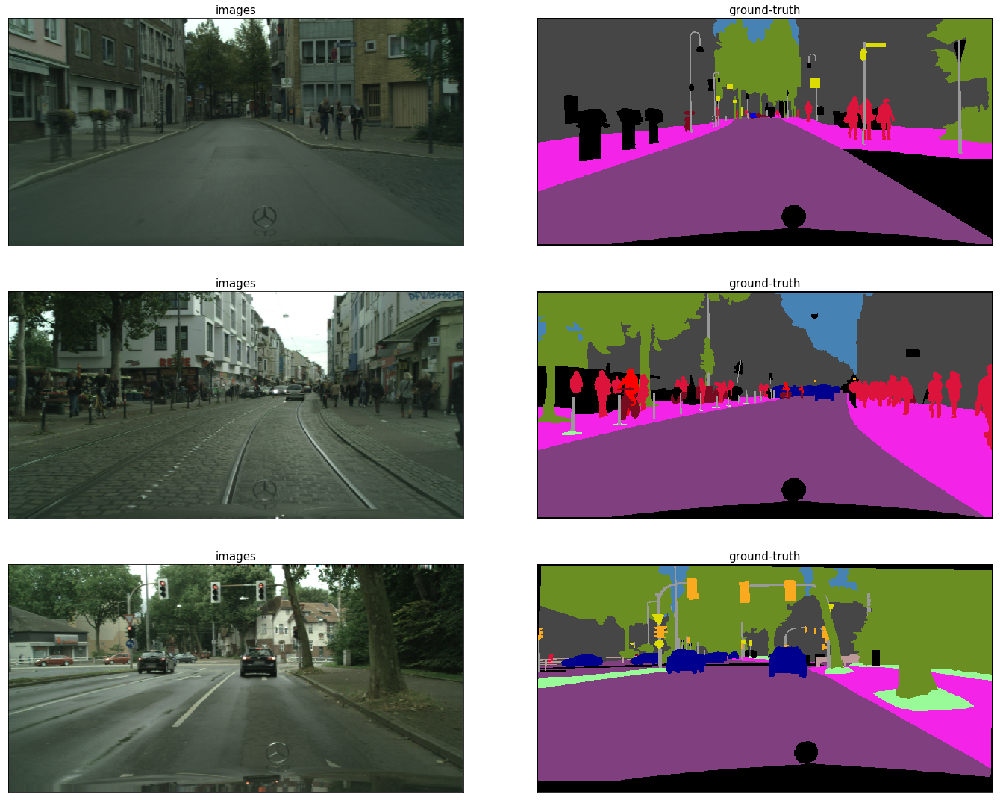

In [13]:
# Simply visualizing the input/target pairs for now:
image_show, predicted_show, gt_show = predict_and_postprocess(val_image_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), gt_show.numpy()], 
                         titles=["images", "ground-truth"])
figure.show()

We will use this function to post-process images, predictions and ground-truths for visualization.

Now preparing our callbacks:

In [11]:
from keras_custom_callbacks import TensorBoardImageGridCallback

model_name = 'cityscapes_unet'
model_dir = os.path.join('models', model_name)

def postprocess_for_grid_callback(input_images, predicted_images, gt_images):
    
    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted_images = tf.math.argmax(predicted_images, axis=-1)
    predicted_images = tf.expand_dims(predicted_images, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        input_images, predicted_images, gt_images, one_hot=True)

    return images_show, predicted_show, gt_show

# Callback to postprocess some validation results and display them in Tensorboard:
callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, 
    input_images=val_image_samples, target_images=val_gt_samples, 
    preprocess_fn=postprocess_for_grid_callback,
    tag=model_name + '_results', figsize=(15, 15))

<Figure size 4500x4500 with 0 Axes>

In [12]:
import collections
from keras_custom_callbacks import SimpleLogCallback

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
                                            ("acc", "acc"), ("v-acc", "val_acc"),
                                            ("mIoU", "mIoU"), ("v-mIoU", "val_mIoU")])

callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)

### Training

Let the training of our _U-Net_ start:

In [16]:
optimizer = tf.keras.optimizers.Adam()

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    callback_tb_grid
]

unet_model.compile(optimizer=optimizer, loss=SegmentationLoss(from_logits=True), 
                    metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])

history = unet_model.fit(
    train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/90: loss = 1.091; v-loss = 2.100; acc = 0.673; v-acc = 0.664; mIoU = 0.141; v-mIoU = 0.125
Epoch  1/90: loss = 0.777; v-loss = 0.882; acc = 0.778; v-acc = 0.775; mIoU = 0.196; v-mIoU = 0.186
Epoch  2/90: loss = 0.673; v-loss = 0.643; acc = 0.811; v-acc = 0.822; mIoU = 0.218; v-mIoU = 0.221
Epoch  3/90: loss = 0.623; v-loss = 0.488; acc = 0.826; v-acc = 0.860; mIoU = 0.230; v-mIoU = 0.257
Epoch  4/90: loss = 0.572; v-loss = 0.586; acc = 0.839; v-acc = 0.828; mIoU = 0.243; v-mIoU = 0.235
Epoch  5/90: loss = 0.548; v-loss = 0.615; acc = 0.845; v-acc = 0.838; mIoU = 0.255; v-mIoU = 0.244
Epoch  6/90: loss = 0.517; v-loss = 0.511; acc = 0.854; v-acc = 0.845; mIoU = 0.265; v-mIoU = 0.267
Epoch  7/90: loss = 0.500; v-loss = 0.409; acc = 0.859; v-acc = 0.875; mIoU = 0.274; v-mIoU = 0.292
Epoch  8/90: loss = 0.483; v-loss = 0.430; acc = 0.863; v-acc = 0.870; mIoU = 0.283; v-mIoU = 0.287
Epoch  9/90: loss = 0.463; v-loss = 0.495; acc = 0.868; v-acc = 0.860; mIoU = 0.290

Epoch 41/90: loss = 0.273; v-loss = 0.376; acc = 0.916; v-acc = 0.881; mIoU = 0.455; v-mIoU = 0.423
Epoch 42/90: loss = 0.272; v-loss = 0.240; acc = 0.916; v-acc = 0.925; mIoU = 0.458; v-mIoU = 0.472
Epoch 43/90: loss = 0.270; v-loss = 0.231; acc = 0.917; v-acc = 0.926; mIoU = 0.456; v-mIoU = 0.474
Epoch 44/90: loss = 0.273; v-loss = 0.284; acc = 0.916; v-acc = 0.915; mIoU = 0.459; v-mIoU = 0.431
Epoch 45/90: loss = 0.264; v-loss = 0.227; acc = 0.918; v-acc = 0.927; mIoU = 0.464; v-mIoU = 0.490
Epoch 46/90: loss = 0.263; v-loss = 0.267; acc = 0.918; v-acc = 0.920; mIoU = 0.472; v-mIoU = 0.468
Epoch 47/90: loss = 0.260; v-loss = 0.236; acc = 0.920; v-acc = 0.925; mIoU = 0.475; v-mIoU = 0.484
Epoch 48/90: loss = 0.259; v-loss = 0.231; acc = 0.919; v-acc = 0.926; mIoU = 0.475; v-mIoU = 0.483
Epoch 49/90: loss = 0.260; v-loss = 0.259; acc = 0.920; v-acc = 0.921; mIoU = 0.478; v-mIoU = 0.475
Epoch 50/90: loss = 0.263; v-loss = 0.258; acc = 0.919; v-acc = 0.921; mIoU = 0.479; v-mIoU = 0.462


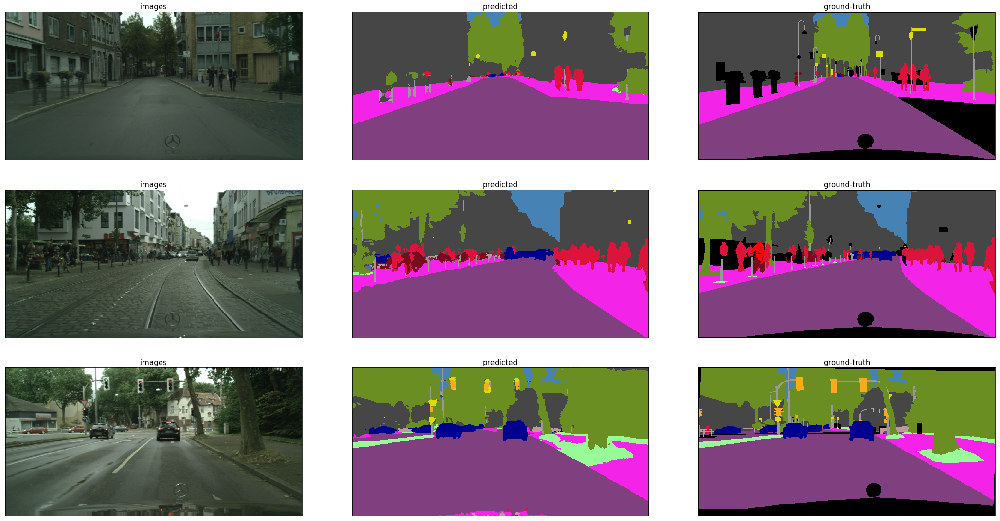

In [17]:
image_show, predicted_show, gt_show = predict_and_postprocess(val_image_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

Unlike our previous _FCN-8s_ model, this _U-Net_ was not partially pre-trained on ImageNet. As we can see, its accuracy is much lower. We can also observe that, like our previous model this time, the network tends to **ignore smaller classes**. While we could try weighing the cross-entropy loss again, we will this time apply a different cost function to avoid this problem.

## Improving the Accuracy of Segmentation Models

In the previous notebook, we have already introduced some weighing strategy to balance the loss functions for complex tasks like object segmentation. In the following section, we will implement and/or re-use some of the other advanced tools we presented by the end of Chapter 6.

### Playing with the _Dice_ loss

In the chapter, we presented the (soft) **_Dice_ loss**[$^{3,4}$](#ref) as another solution to train a model for semantic segmentation which would not suffer for the **class imbalance**.

In [14]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_multilabel(y_true, y_pred, num_classes=num_classes):
    y_true = tf.cast(tf.squeeze(y_true), tf.int32)
    y_true = tf.one_hot(y_true, num_classes)
    y_true = tf.reshape(y_true, tf.shape(y_pred))
        
    dice = 0
    for i in range(num_classes):
        dice -= dice_coef(y_true[..., i], y_pred[..., i])
    return dice


@tf.function
def dice_loss(y_true, y_pred, ignore_value=CITYSCAPES_IGNORE_VALUE,
              eps=1e-6, spatial_axes=[1, 2], from_logits=False):
    """
    Compute the Dice loss for semantic segmentation, ignoring pixels from some misc. classes.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :param eps:           Epsilon small value (smooth) 
    :param spatial_axes:  Spatial axes
    :param from_logits:   Flag if predictions are logits (not normalized)
    :return:              Loss value
    """
    num_classes = y_pred.shape[-1]
        
    # (opt.) Build mask to remove pixels from ignored classes:
    # if ignore_value is not None:
    #     y_true, y_pred = prepare_data_for_segmentation_loss(
    #         y_true, y_pred, num_classes=num_classes, ignore_value=ignore_value)

    # Transform logits in probabilities, and one-hot the ground-truth:
    if from_logits:
        y_pred = tf.nn.softmax(y_pred, axis=-1)
    y_true = tf.squeeze(tf.cast(y_true, tf.int32), axis=-1)
    y_true_onehot  = tf.one_hot(y_true, num_classes, dtype=y_pred.dtype)

    # (opt.) Build mask to remove pixels from ignored classes:
    if ignore_value is not None:
        mask_for_valid_labels = get_mask_for_valid_labels(
            y_true, num_classes, ignore_value=ignore_value)
        mask_for_valid_labels = tf.cast(mask_for_valid_labels, y_pred.dtype)
        mask_for_valid_labels = tf.expand_dims(mask_for_valid_labels, axis=-1)
        y_pred = y_pred * mask_for_valid_labels
        y_true_onehot = y_true_onehot * mask_for_valid_labels

    # Compute Dice numerator and denominator:
    num_perclass = 2 * tf.reduce_sum(y_pred * y_true_onehot, axis=spatial_axes)
    den_perclass = tf.reduce_sum(y_pred + y_true_onehot, axis=spatial_axes)

    # Compute Dice and average over batch and classes:
    dice = tf.reduce_mean((num_perclass + eps) / (den_perclass + eps))

    return 1 - dice


class DiceLoss(tf.losses.Loss):
    def __init__(self, ignore_value=CITYSCAPES_IGNORE_VALUE,
                  eps=1e-6, spatial_axes=[1, 2], from_logits=False, name='loss'):
        """
        Initialize the loss.
        :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
        :param eps:           Epsilon small value (smooth) 
        :param spatial_axes:  Spatial axes
        :param from_logits:   Flag if predictions are logits (not normalized)
        :param name:          Name
        """
        super().__init__(name=name)
        self.ignore_value = ignore_value
        self.eps = eps
        self.spatial_axes = spatial_axes
        self.from_logits = from_logits
    
    def _prepare_data(self, y_true, y_pred):
        num_classes = y_pred.shape[-1]
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=num_classes, 
                                                            ignore_value=self.ignore_value)
        return y_true, y_pred
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        """
        Compute the Dice loss for semantic segmentation, ignoring pixels from some misc. classes.
        :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
        :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
        :param sample_weight: opt. weight tensor, broadcastable to `y_true`
        :return:              Loss value
        """
        return dice_loss(y_true, y_pred, ignore_value=self.ignore_value, eps=self.eps, 
                         spatial_axes=self.spatial_axes, from_logits=self.from_logits)

Let us train our model with this new loss:

In [15]:
import glob

# Opt., if the notebook was interrupted or something, we can warm-start/restore the weights
# previously trained:
SHOULD_RELOAD_WEIGHTS = True

if SHOULD_RELOAD_WEIGHTS:
    reload_from = os.path.join('models', 'cityscapes_unet', 'weights-epoch*')
    weight_files = sorted(glob.glob(reload_from))
    weight_file = weight_files[-1] # in this case, we simply take the latest file
    
    unet_model.load_weights(weight_file)
    print("U-Net - restored weights from {}".format(weight_file))


batch_size = 4 # reducing batch size if not enough GPU

model_name = 'cityscapes_unet_dice'
model_dir = os.path.join('models', model_name)

# Callbacks:
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model (e.g., every 5 epochs), specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, input_images=val_image_samples, target_images=val_gt_samples, 
        preprocess_fn=postprocess_for_grid_callback,
        tag=model_name + '_results', figsize=(15, 15))
]

# Compile:
optimizer = tf.keras.optimizers.Adam()
unet_model.compile(optimizer=optimizer, loss=DiceLoss(from_logits=True), 
                    metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])

# Train: initial_epoch
history_dice = unet_model.fit(
    train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

U-Net - restored weights from models/cityscapes_unet/weights-epoch75-loss0.20.h5


W0403 14:47:09.580404 139793519175424 deprecation.py:323] From /home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/confusion_matrix.py:194: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0403 14:47:09.582283 139793519175424 deprecation.py:323] From /home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/confusion_matrix.py:195: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Training: start.
Epoch  0/90: loss = 0.597; v-loss = 0.593; acc = 0.927; v-acc = 0.926; mIoU = 0.552; v-mIoU = 0.531
Epoch  1/90: loss = 0.589; v-loss = 0.585; acc = 0.927; v-acc = 0.928; mIoU = 0.550; v-mIoU = 0.555
Epoch  2/90: loss = 0.587; v-loss = 0.576; acc = 0.927; v-acc = 0.934; mIoU = 0.557; v-mIoU = 0.569
Epoch  3/90: loss = 0.584; v-loss = 0.580; acc = 0.926; v-acc = 0.925; mIoU = 0.558; v-mIoU = 0.555
Epoch  4/90: loss = 0.582; v-loss = 0.586; acc = 0.927; v-acc = 0.922; mIoU = 0.559; v-mIoU = 0.552
Epoch  5/90: loss = 0.580; v-loss = 0.576; acc = 0.927; v-acc = 0.928; mIoU = 0.565; v-mIoU = 0.546
Epoch  6/90: loss = 0.578; v-loss = 0.569; acc = 0.928; v-acc = 0.935; mIoU = 0.570; v-mIoU = 0.578
Epoch  7/90: loss = 0.577; v-loss = 0.575; acc = 0.927; v-acc = 0.928; mIoU = 0.569; v-mIoU = 0.567
Epoch  8/90: loss = 0.575; v-loss = 0.569; acc = 0.928; v-acc = 0.934; mIoU = 0.576; v-mIoU = 0.577
Epoch  9/90: loss = 0.574; v-loss = 0.565; acc = 0.928; v-acc = 0.934; mIoU = 0.576

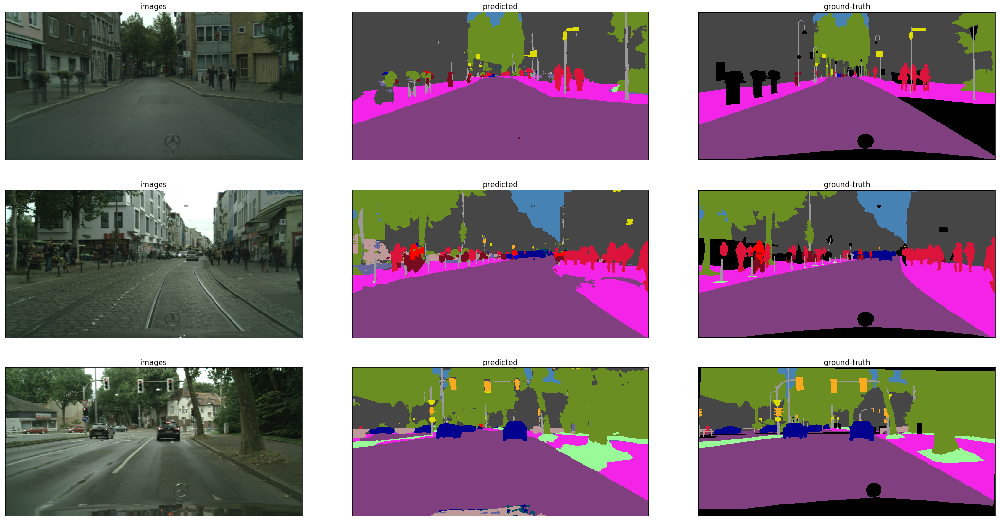

In [16]:
image_show, predicted_show, gt_show = predict_and_postprocess(val_image_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

Though still below our _FCN-8s_ pre-trained on ImageNet in terms of accuracy, we can appreciate how our model improved with the use of the _Dice_ loss. Smaller classes (like traffic signs, traffic lights, poles, etc.) are no longer completely ignored.

**Note:** To keep the length of this notebook reasonable, we will not further refine our current model. Several methods could be considered though. For instance:

- **Transfer learning**. Pre-training our U-Net (or at least some of its layers) on another task/dataset is a sure way of improving its performance. For example, since datasets for semantic segmentation can be hard to find/gather, we could just train its encoding layers (extended with some fully-connected layers) to classify some large dataset like ImageNet.
- **Loss weighing/combining**. If we wanted to put some emphasis on specific classes, nothing prevents us from applying some of the weighing strategies covered in the last notebook. The _Dice_ loss could even be extended with a cross-entropy component.
- **Multi-task training**. It is common to build encoder-decoder models with multiple decoders for a single encoder. Each decoder is then usually tackling a different task (e.g., semantic segmentation, contour extraction, depth regression, etc.). Because of the synergy between these tasks, each decoder of such multi-task models often performs better than if it were trained alone. We could thus extend our model with another decoder, tackling some auxiliary task (like contour extraction, since we know from the last notebook how to obtain some ground-truth outlines).
- etc.

### Post-processing with Conditional Random Fields (CRFs)

As detailed in Chapter 6, there are several available methods to post-process the pixel-level predictions of CNNs, and the **_Conditional Random Fields (CRFs)_** are probably the most popular.

We will here reuse the [`pydensecrf`](https://github.com/lucasb-eyer/pydensecrf) module by Lucas Beyer[$^5$](#ref), a Python wrapper for the dense CRFs with Gaussian edge by  Philipp Krähenbühl and Vladlen Koltun[$^6$](#ref). How to use this framework is presented in the last notebook for this chapter.

In [17]:
# Uncomment below to install the module and its dependencies from the notebook:
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-p3l386d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-gckon1b5/wheels/81/ac/ed/09f1890b954ca1ff7f189518cc9a319138e50e7ea88937fae9
Successfully built pydensecrf
You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
from pydensecrf import densecrf
from pydensecrf.utils import (
    unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral, compute_unary)

Taking into account how close pixels are, spatially and color-wise, as well as some imperfect probability map in our case, the _softmax_ predictions from  our CNN), CRF methods return refined label maps which better respect visual contours. Following the instructions of [`pydensecrf`](https://github.com/lucasb-eyer/pydensecrf), we thus build the following method to post-process our predicted maps:

In [19]:
import numpy as np

def crf_postprocessing(input_image, predicted_probabilities):
    """
    Use CRF to post-process the predicted label maps.
    :param input_image:               Original input RGB image (of shape H x W x 3)
    :param predicted_probabilities:   Predicted softmax map(s) 
                                      (of shape H x W x N, N number of classes)
    :return:                          Refined softmax map as numpy array
                                      (of shape H x W x N)
    """
    
    num_classes = predicted_probabilities.shape[-1]
    h, w = input_image.shape[:2]
    
    d = densecrf.DenseCRF2D(w, h, num_classes)
    
    
    # densecrf needs the predictions to be channel-first, so we transpose them:
    # input_image = np.ascontiguousarray(input_image.transpose((2, 0, 1)))
    predicted_probabilities = np.ascontiguousarray(predicted_probabilities.transpose((2, 0, 1)))

    # For the predictions, densecrf actually needs the unary values, i.e. -log(proba):
    # predicted_unary = np.ascontiguousarray(softmax_to_unary(predicted_probabilities))
    predicted_unary = unary_from_softmax(predicted_probabilities)
    d.setUnaryEnergy(predicted_unary)

    # densecrf takes into account additional features to refine the predicted label maps.
    # First, as explained in the `pydensecrf` repo, we add the color-independent term, 
    # where features are the locations only:
    d.addPairwiseGaussian(sxy=(20, 20), compat=10, kernel=densecrf.DIAG_KERNEL,
                          normalization=densecrf.NORMALIZE_SYMMETRIC)

    # Then we add the color-dependent term, i.e. features are (x,y,r,g,b) based on the input image:
    input_image_uint = (input_image * 255).astype(np.uint8)
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(5, 5, 5), rgbim=input_image_uint,
                           compat=10, kernel=densecrf.DIAG_KERNEL, 
                           normalization=densecrf.NORMALIZE_SYMMETRIC)

    # Finally, we run several inference to obtain the refined predictions:
    refined_predictions = np.array(d.inference(5)).reshape(num_classes, h, w)
    
    # We switch back to channel-last, for consistency:
    refined_predictions = np.transpose(refined_predictions, (1, 2, 0))
    
    return refined_predictions

Let us try on some samples:

In [20]:
# Add softmax layer to our model:
softmax_outputs = tf.keras.layers.Softmax(axis=-1)(unet_model.outputs[0])
unet_model_with_softmax = Model(unet_model.inputs, softmax_outputs)

def predict_with_crf(images):
    """
    Use the model and CRF to predict the label map, 
    and post-process the data for visualization.
    :param images:      Images
    :return:            Predictions before/after CRF
    """

    # Predict and post-process with CRFs:
    preds_softmax = unet_model_with_softmax.predict(images)
    
    preds_crf_softmax = []
    for i in range(len(images)):
        pred_crf_softmax = crf_postprocessing(images[i], preds_softmax[i])
        preds_crf_softmax.append(pred_crf_softmax)
    preds_crf_softmax = np.stack(preds_crf_softmax)

    preds_softmax = tf.constant(preds_softmax)
    preds = tf.math.argmax(preds_softmax, axis=-1)

    preds_crf_softmax = tf.constant(preds_crf_softmax)
    preds_crf = tf.math.argmax(preds_crf_softmax, axis=-1) 
    
    return preds_softmax, preds, preds_crf_softmax, preds_crf

preds_softmax, preds, preds_crf_softmax, preds_crf = predict_with_crf(val_image_samples.numpy())

Acc. = 93.80% ; Acc. w/ CRF = 93.89%	|	 mIoU =  0.48 ; mIoU w/ CRF =  0.47.


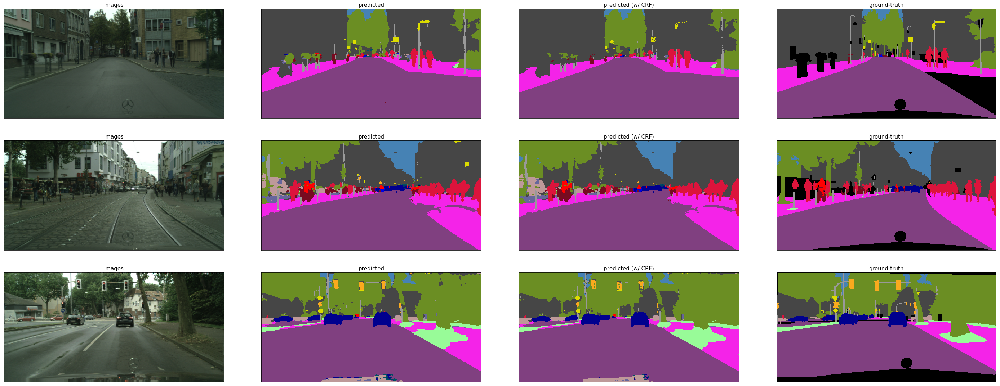

In [21]:
# Postprocess for display:
image_show, pred_show, gt_show = postprocess_to_show(
    val_image_samples, tf.expand_dims(preds, axis=-1), val_gt_samples, one_hot=True)
pred_crf_show = tf.squeeze(postprocess_to_show(
    None, tf.expand_dims(preds_crf, axis=-1), one_hot=True))

# Additionally, we compute some metrics:
acc_fn  = SegmentationAccuracy()
acc     = acc_fn(val_gt_samples, preds_softmax)
acc_crf = acc_fn(val_gt_samples, preds_crf_softmax)

miou_fn  = SegmentationMeanIoU(num_classes)
miou     = miou_fn(val_gt_samples, preds_softmax)
miou_crf = miou_fn(val_gt_samples, preds_crf_softmax)

figure = plot_image_grid(
    [image_show.numpy(), pred_show.numpy(), pred_crf_show.numpy(), gt_show.numpy()], 
    titles=["images", "predicted", "predicted (w/ CRF)", "ground-truth"])
figure.show()

print('Acc. = {0:5.2f}% ; Acc. w/ CRF = {1:5.2f}%\t|\t mIoU = {2:5.2f} ; mIoU w/ CRF = {3:5.2f}.'.format(
    acc.numpy() * 100, acc_crf.numpy() * 100, miou, miou_crf))

The changes are rather subtle here, but we can still notice some improvement in terms of accuracy. Moreover, the various hyper-parameters of the CRF method could be better tuned (`sxy`, `srgb`, `compat`), though it has to be done with care (e.g., with too high values, the resulting label map could be too smoothed, and smaller details/classes could be lost)

## Achieving Instance Segmentation

In the book, we presented two ways of tackling instance segmentation. In the continuation of this notebook, we will apply the first method: **transforming class label maps into instance maps using morphological methods**.

More precisely, we will simply apply a pre-trained version of the _Deep Watershed Transform for Instance Segmentation_[$^7$](#ref) by Min Bai and Raquel Urtasun, introduced in the chapter. This TensorFlow model, pre-trained on Cityscapes, was made available on GitHub by the paper's authors: [`dwt`](https://github.com/min2209/dwt). However, as its code was written in Python 2 and using a deprecated version of TensorFlow, we provide an updated version (forked from the original repository), either added as a submodule in this folder ([`./dwt_python3`](./dwt_python3)) or downloadable from the GitHub repository [`dwt`](https://github.com/Aldream/dwt) forked by the authors.

As mentioned, the _DWT_ authors are providing a pre-trained model, targetting instances of cars, persons, bikes, etc. We thus download the pre-trained-parameters:

In [22]:
# Download the DWT pre-trained parameters provided by the authors:
!mkdir ./dwt_python3/model
!wget http://www.cs.toronto.edu/~mbai/dwt_cityscapes_pspnet.mat -P ./dwt_python3/model/

mkdir: cannot create directory ‘./dwt_python3/model’: File exists
--2019-04-03 17:28:58--  http://www.cs.toronto.edu/~mbai/dwt_cityscapes_pspnet.mat
Connecting to 194.145.60.1:9400... connected.
Proxy request sent, awaiting response... 200 OK
Length: 152663376 (146M)
Saving to: ‘./dwt_python3/model/dwt_cityscapes_pspnet.mat.5’

dwt_cityscapes_pspn 100%[===================>] 145.59M  1022KB/s    in 89s     

2019-04-03 17:30:28 (1.64 MB/s) - ‘./dwt_python3/model/dwt_cityscapes_pspnet.mat.5’ saved [152663376/152663376]



We can now initialize their model:

In [23]:
from dwt_python3.E2E.network_init import get_model
from dwt_python3.E2E.io_utils import ssProcess
from dwt_python3.E2E.post_process import watershed_cut

dwt_model_weight_path =  ["./dwt_python3/model/dwt_cityscapes_pspnet.mat"]

# Building DWT model
pred_crf_input = tf.keras.layers.Input(dtype=tf.float32, shape=preds_crf.shape[-2:])
pred_crf_bin_input = tf.keras.layers.Input(dtype=tf.float32, shape=preds_crf.shape[-2:])
orig_image_input = inputs

dwt_model = get_model(modelWeightPaths=dwt_model_weight_path)
# dwt_model = tf.keras.Model([orig_image_input, pred_crf_input, pred_crf_bin_input],
#                            dwt_model.outputDataArgMax, name="dwt")


# TF1 code:
# 
# from dwt_python3.E2E.network_init import get_model
# from dwt_python3.E2E.io_utils import ssProcess
# from dwt_python3.E2E.post_process import watershed_cut
# 
# dwt_model_weight_path =  ["./dwt_python3/model/dwt_cityscapes_pspnet.mat"]
# 
# # Building DWT model
# cb_pred_crf_placeholder = tf.placeholder(dtype=tf.float32, shape=preds_crf.shape)
# cb_pred_crf_bin_placeholder = tf.placeholder(dtype=tf.float32, shape=preds_crf.shape)
# dwt_model = get_model(modelWeightPaths=dwt_model_weight_path)
# dwt_model.build(cb_img_placeholder, cb_pred_crf_placeholder, cb_pred_crf_bin_placeholder, 
#                 keepProb=tf.constant(1.))
# session.run(tf.initialize_all_variables())

Instance prediction based on our previous segmentation results:

In [24]:
# Processing data before prediction:
pred, pred_mask = ssProcess(preds_crf.numpy())

# Predicting:
# (the DWT model was implemented with an old version of TensorFlow 1. We quickly adapted
# the code base to TensorFlow 2, converting the model-building method directly into a
# model-inference one. However, we didn't rename this method accordingly to stick to the
# original structure. Note that, while this is fine for a one-time inference, this solution
# isnot optimized, e.g., for training.)
dwt_model.build(val_image_samples, pred, pred_mask, keepProb=tf.constant(1.))
# ^ aka dwt_model.predict([val_image_samples, pred, pred_mask])

# Inference result is stored as the attribute `.outputDataArgMax` of the model:
dwt_pred = dwt_model.outputDataArgMax.numpy() 

instance_samples = [watershed_cut(dwt_pred[i], pred_mask[i]) for i in range(len(dwt_pred))]
instance_samples = tf.convert_to_tensor(instance_samples)

# TF1 code:
#
# # Processing data before prediction:
# pred, pred_mask = ssProcess(preds_crf)
# 
# # Predicting:
# dwt_pred = session.run(dwt_model.outputDataArgMax, 
#                        feed_dict={cb_img_placeholder: input_samples,
#                                   cb_pred_crf_placeholder: pred,
#                                   cb_pred_crf_bin_placeholder: pred_mask})
# instance_samples = [watershed_cut(dwt_pred[i], pred_mask[i]) for i in range(len(dwt_pred))]
# instance_samples = np.stack(instance_samples)
# """

building direction net
loaded direction/conv1_1/weights
loaded direction/conv1_1/biases
loaded direction/conv1_2/weights
loaded direction/conv1_2/biases
loaded direction/conv2_1/weights
loaded direction/conv2_1/biases
loaded direction/conv2_2/weights
loaded direction/conv2_2/biases
loaded direction/conv3_1/weights
loaded direction/conv3_1/biases
loaded direction/conv3_2/weights
loaded direction/conv3_2/biases
loaded direction/conv3_3/weights
loaded direction/conv3_3/biases
loaded direction/conv4_1/weights
loaded direction/conv4_1/biases
loaded direction/conv4_2/weights
loaded direction/conv4_2/biases
loaded direction/conv4_3/weights
loaded direction/conv4_3/biases
loaded direction/conv5_1/weights
loaded direction/conv5_1/biases
loaded direction/conv5_2/weights
loaded direction/conv5_2/biases
loaded direction/conv5_3/weights
loaded direction/conv5_3/biases
loaded direction/fcn5_1/weights
loaded direction/fcn5_1/biases
loaded direction/fcn5_2/weights
loaded direction/fcn5_2/biases
loaded

/home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


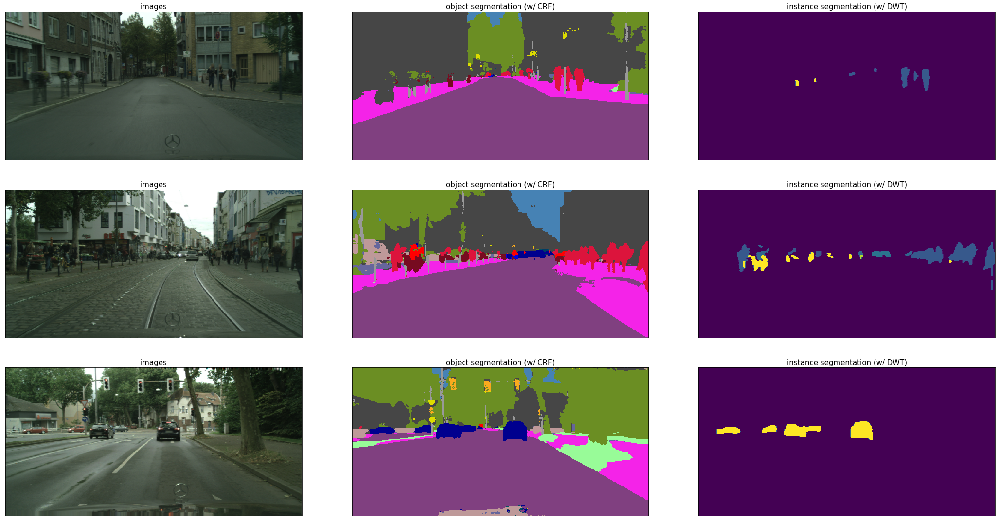

In [25]:
# Displaying:
image_show, gt_show = postprocess_to_show(val_image_samples, val_gt_samples)
instance_show = tf.squeeze(postprocess_to_show(
    tf.expand_dims(instance_samples, axis=-1)))
instance_show = instance_show ** 4 # to accentuate the difference of colors between instances

figure = plot_image_grid([
    image_show.numpy(), pred_crf_show.numpy(), instance_show.numpy()], 
    titles=["images", "object segmentation (w/ CRF)", "instance segmentation (w/ DWT)"])
figure.show()

The _DWT_ model definitely did something to our input images and label maps, though the visualized results are not that explicit.

However if we check the _DWT_ repository, we can actually read that:

    "[...] each pixel is labeled as `id * 1000 + instance_id`, where `id` is as defined by Cityscapes (for more information, consult labels.py in the above link), and `instance_id` is an integer indexing the object instance."
    
Indeed, if we check the values of our _DWT_ predictions, we can values like `24001, 24002, ..., 26001, ...` (`24` is the ID of the `person` class in Cityscapes, `26` of `car`, etc.):

In [26]:
# Let's check the values our instance tensors contain:
print("Instance label values:\n", np.unique(instance_samples))

Instance label values:
 [    0 24001 24002 24003 24004 24005 24006 24007 25001 25002 25003 25004
 26001 26002 26003 26004 32001 33001 33002 33003 33004 33005 33006 33007
 33008]


With this information, we can now properly use our _DWT_ results. For instance, to display the `car` instances in our sample images:

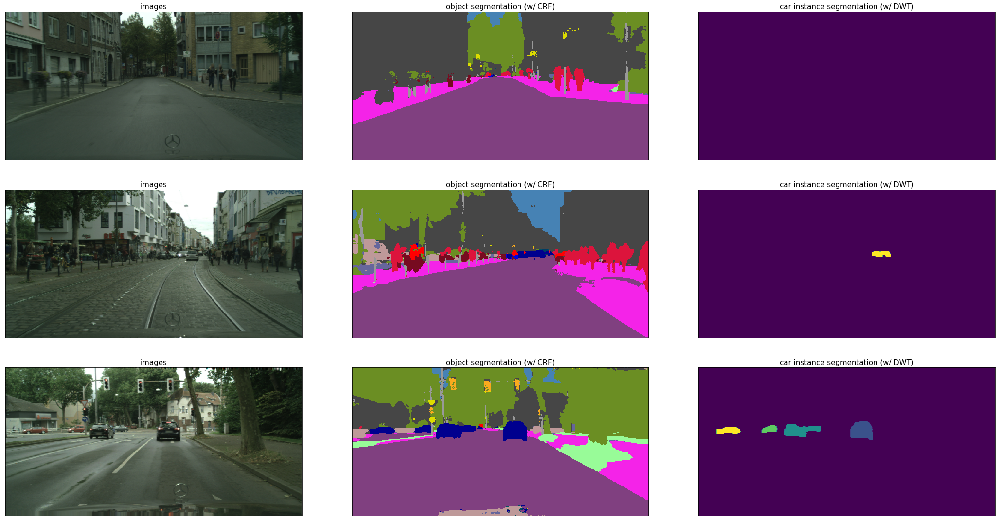

In [27]:
import cityscapesscripts.helpers.labels as cityscapes_labels

car_label = cityscapes_labels.name2label['car']
car_instance_mask = tf.equal((instance_samples // 1000), car_label.id)

car_instance_samples = instance_samples
car_instance_samples = tf.where(car_instance_mask,                  # condition
                                car_instance_samples,               # if True, keep value
                                tf.zeros_like(car_instance_samples))# if False, put 0
car_instance_samples = car_instance_samples % 1000

# Displaying:
instance_show = postprocess_to_show(tf.expand_dims(car_instance_samples, axis=-1))
instance_show = (tf.squeeze(instance_show) * 255) / tf.reduce_max(instance_show)

figure = plot_image_grid([
    image_show.numpy(), pred_crf_show.numpy(), instance_show.numpy()], 
    titles=["images", "object segmentation (w/ CRF)", "car instance segmentation (w/ DWT)"])
figure.show()

Now that we covered all the various tools (segmentation models, advanced losses, _CRF_ post-processing, _DWT_ processing, etc.), we leave it to our readers to tune their pipeline (e.g., replacing our _U-Net_ with _FCN-8s_, or pre-training _U-NET_, etc.) or to check some other state-of-the-art methods (e.g., _Mask-RCNN_).

## Conclusion

From simple auto-encoding on MNIST to instance segmentation on urban scenes, we covered a lot of notions and tools in this Chapter 6 and its related notebooks. Once again, we invite our readers to take some time applying all these methods to different tasks for instance.

<a id="ref"></a>
#### References

1. Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., Franke, U., Roth, S., Schiele, B., 2016. The Cityscapes Dataset for Semantic Urban Scene Understanding. In: 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Presented at the 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, Las Vegas, NV, USA, pp. 3213–3223.
2. Ronneberger, O., Fischer, P., Brox, T., 2015. U-Net: Convolutional Networks for Biomedical Image Segmentation. arXiv:1505.04597 [cs].
3. Dice, L.R., 1945. Measures of the amount of ecologic association between species. Ecology 26, 297–302.
4. Sørensen, T., 1948. A method of establishing groups of equal amplitude in plant sociology based on similarity of species and its application to analyses of the vegetation on Danish commons. Biol. Skr. 5, 1–34.
5. Beyer, L., 2019. Python wrapper to Philipp Krähenbühl’s dense (fully connected) CRFs with gaussian edge potentials.: lucasb-eyer/pydensecrf.
6. Krähenbühl, P., Koltun, V., n.d. Efficient Inference in Fully Connected CRFs with Gaussian Edge Potentials 9.
7. Bai, M., Urtasun, R., 2016. Deep Watershed Transform for Instance Segmentation. arXiv:1611.08303 [cs].